# COMAP 2023 Wordle (Problem C) # 2316611

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import urllib
from util import *
from matplotlib import cycler

plt.style.use('fivethirtyeight')

colors = ['#16b713','#1A8FE3','#38369A','#9810B3','#D11149','#FF6201','#f3ba07']
plt.rc('axes',prop_cycle=cycler('color',colors))

In [55]:
# source: https://github.com/tabatkins/wordle-list
ALLOWED_WORDS_FILE = 'https://raw.githubusercontent.com/tabatkins/wordle-list/main/words'
allowed_words = urllib.request.urlopen(ALLOWED_WORDS_FILE).read().decode().split()

In [56]:
len(allowed_words)

14855

In [4]:
DATA_FILE = '../data/Problem_C_Data_Wordle.xlsx'
df = pd.read_excel(DATA_FILE,header=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3


In [5]:
df.rename(columns={'Date':'date','Contest number':'contest_num','Word':'word','Number of  reported results':'num_results','Number in hard mode':'num_hardmode','1 try':'in1','2 tries':'in2','3 tries':'in3','4 tries':'in4','5 tries':'in5','6 tries':'in6','7 or more tries (X)':'over6'},inplace=True)

In [6]:
df[~df.word.isin(allowed_words)]

,date,contest_num,word,num_results,num_hardmode,in1,in2,in3,in4,in5,in6,over6
15,2022-12-16,545,rprobe,22853,2160,0,6,24,32,24,11,3
20,2022-12-11,540,naïve,21947,2075,1,7,24,32,24,11,1
35,2022-11-26,525,clen,26381,2424,1,17,36,31,12,3,0
87,2022-10-05,473,marxh,30935,2885,0,9,30,35,19,6,1
246,2022-04-29,314,tash,106652,7001,2,19,34,27,13,4,1
353,2022-01-12,207,favor,137586,3073,1,4,15,26,29,21,4


In [7]:
df.loc[15,'word'] = 'probe'
df.loc[20,'word'] = 'naive'
df.loc[35,'word'] = 'clean'
df.loc[87,'word'] = 'marsh'
df.loc[246,'word'] = 'trash'
df.loc[353,'word'] = 'favor'

In [8]:
letter_freqencies = calculate_freqs()
letter_freqencies = sorted(letter_freqencies.items(), key=lambda x:x[1],reverse=True)
letter_freqencies

letters,_=zip(*letter_freqencies)
letters

order_freqs = {}
for i in range(26):
    order_freqs[letters[i]] = i

In [9]:
df['letter1'] = df.word.apply(lambda x: x[0])
df['letter2'] = df.word.apply(lambda x: x[1])
df['letter3'] = df.word.apply(lambda x: x[2])
df['letter4'] = df.word.apply(lambda x: x[3])
df['letter5'] = df.word.apply(lambda x: x[4])

df['letter1_int'] = df.letter1.apply(lambda x: order_freqs[x])
df['letter2_int'] = df.letter2.apply(lambda x: order_freqs[x])
df['letter3_int'] = df.letter3.apply(lambda x: order_freqs[x])
df['letter4_int'] = df.letter4.apply(lambda x: order_freqs[x])
df['letter5_int'] = df.letter5.apply(lambda x: order_freqs[x])

In [10]:
# average number of guesses (counting over 6 as 7 guesses)
df['avg_num_guesses'] = (df['in1']+df['in2']*2+df['in3']*3+df['in4']*4+df['in5']*5+df['in6']*6+df['over6']*7)/100

In [11]:
df['day_of_week'] = df.date.dt.day_of_week

In [12]:
df['word_score'] = df.word.apply(lambda word: word_score(word))
df['word_occurrence'] = df.word.apply(lambda word: occurrence_score(word))
df['vowels'] = df.word.apply(count_vowels)
df['repeats'] = df.word.apply(count_repeats)

In [13]:
df.head()

,date,contest_num,word,num_results,num_hardmode,in1,in2,in3,in4,in5,...,letter2_int,letter3_int,letter4_int,letter5_int,avg_num_guesses,day_of_week,word_score,word_occurrence,vowels,repeats
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,...,2,8,6,13,4.34,5,1.292494,0.001632,1,0
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,...,3,6,2,4,4.14,4,1.564995,0.001400,2,0
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,...,2,21,3,14,4.40,3,1.169976,0.000796,2,0
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,...,12,11,0,6,4.15,2,1.377718,0.000204,2,0
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,...,3,8,10,3,4.45,1,1.271154,0.000276,2,1


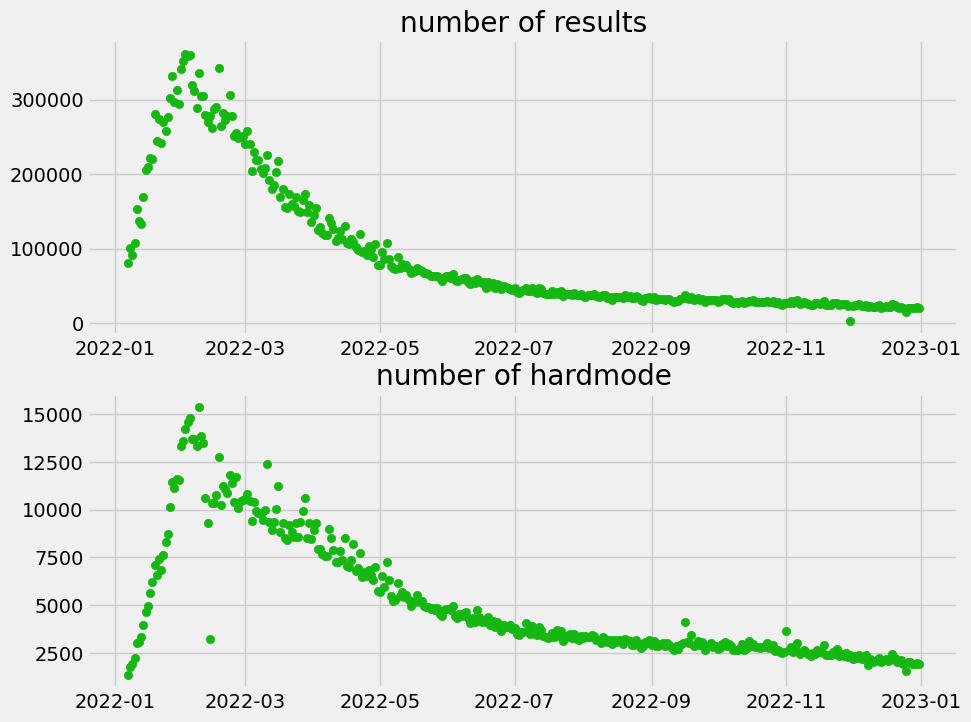

In [14]:
fig = plt.figure(figsize=(10,8))

fig.add_subplot(211)
plt.title('number of results')
plt.scatter(df.date,df.num_results)

fig.add_subplot(212)
plt.title('number of hardmode')
plt.scatter(df.date,df.num_hardmode)

plt.show()

In [35]:
# https://twitter.com/WordleStats/status/1596187171039244288?cxt=HHwWgMCjzc3x5aYsAAAA
df.loc[321,'num_hardmode'] = 2725

# https://mobile.twitter.com/WordleStats/status/1587852240412254208
df.loc[298,'num_hardmode'] = 2667

# https://twitter.com/WordleStats/status/1598361495703670784?cxt=HHwWgMCi4frTwq4sAAAA
df.loc[327,'num_results'] = 25569

# https://twitter.com/WordleStats/status/1493268878998179840
df.loc[37,'num_hardmode'] = 9249

In [36]:
# df.loc[321,'num_hardmode'] = 2725
df.iloc[37]

date               2022-02-13 00:00:00
contest_num                        239
word                             robin
num_results                     277471
num_hardmode                      9249
in1                                  1
in2                                  6
in3                                 29
in4                                 34
in5                                 21
in6                                  8
over6                                1
letter1                              r
letter2                              o
letter3                              b
letter4                              i
letter5                              n
letter1_int                          4
letter2_int                          3
letter3_int                         17
letter4_int                          5
letter5_int                          8
avg_num_guesses                   3.96
day_of_week                          6
word_score                     1.32171
word_occurrence          

In [37]:
df[df.num_hardmode == df[df.date.dt.month==11].num_hardmode.max()]

,date,contest_num,word,num_results,num_hardmode,in1,in2,in3,in4,in5,...,letter2_int,letter3_int,letter4_int,letter5_int,avg_num_guesses,day_of_week,word_score,word_occurrence,vowels,repeats
303,2022-11-06,505,stale,31068,3013,2,19,30,27,15,...,7,2,6,0,3.63,6,1.978391,0.001121,2,0


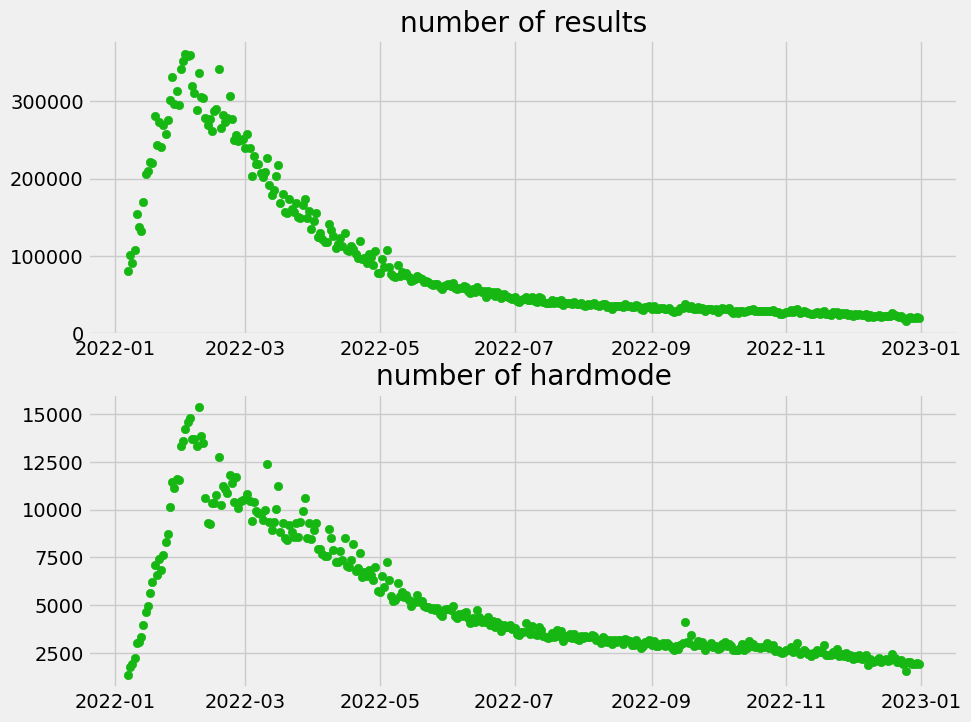

In [38]:
fig = plt.figure(figsize=(10,8))

fig.add_subplot(211)
plt.title('number of results')
plt.scatter(df.date,df.num_results)

fig.add_subplot(212)
plt.title('number of hardmode')
plt.scatter(df.date,df.num_hardmode)

plt.show()

In [39]:
distribution_cols = ['in1', 'in2', 'in3', 'in4', 'in5', 'in6', 'over6']
distribution = df[distribution_cols]

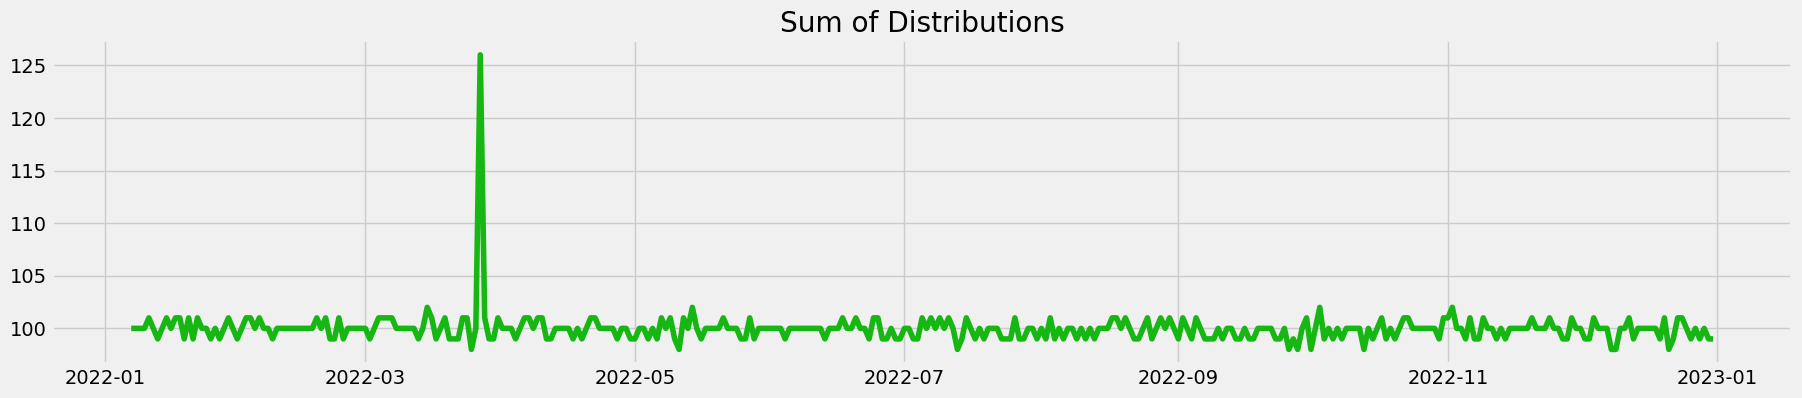

In [40]:
fig = plt.figure(figsize=(20,4))

plt.title('Sum of Distributions')
plt.plot(df.date,distribution.sum(axis=1))
plt.show()

In [41]:
distribution[distribution.sum(axis=1) > 101].sum(axis=1)

67     102
79     126
127    102
269    102
299    102
dtype: int64

In [42]:
df.iloc[79]

date               2022-03-27 00:00:00
contest_num                        281
word                             nymph
num_results                     165468
num_hardmode                      9935
in1                                  1
in2                                  2
in3                                 18
in4                                 44
in5                                 26
in6                                 26
over6                                9
letter1                              n
letter2                              y
letter3                              m
letter4                              p
letter5                              h
letter1_int                          8
letter2_int                         13
letter3_int                         12
letter4_int                         11
letter5_int                         15
avg_num_guesses                   5.84
day_of_week                          6
word_score                    0.856345
word_occurrence          

In [43]:
# https://twitter.com/WordleStats/status/1508489249988902912

df.loc[79,'in6'] = 9
df.loc[79,'over6'] = 1

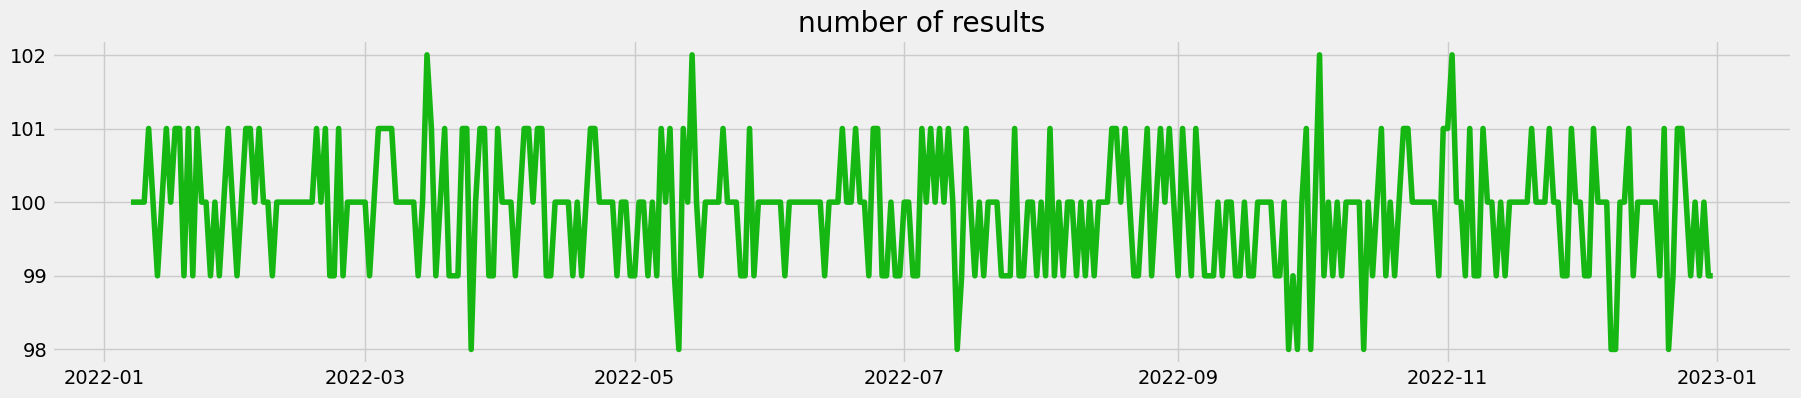

In [44]:
distribution_cols = ['in1', 'in2', 'in3', 'in4', 'in5', 'in6', 'over6']
distribution = df[distribution_cols]

fig = plt.figure(figsize=(20,4))

plt.title('number of results')
plt.plot(df.date,distribution.sum(axis=1))
plt.show()

In [45]:
df.sort_values(by='date',inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,date,contest_num,word,num_results,num_hardmode,in1,in2,in3,in4,in5,...,letter2_int,letter3_int,letter4_int,letter5_int,avg_num_guesses,day_of_week,word_score,word_occurrence,vowels,repeats
0,2022-01-07,202,slump,80630,1362,1,3,23,39,24,...,6,9,12,11,4.13,4,1.270683,0.000419,1,0
1,2022-01-08,203,crank,101503,1763,1,5,23,31,24,...,4,2,8,18,4.22,5,1.300505,0.001037,1,0
2,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,...,3,4,16,0,4.64,6,1.421003,0.001064,2,1
3,2022-01-10,205,query,107134,2242,1,4,16,30,30,...,9,0,4,13,4.43,0,1.187546,0.003178,2,0
4,2022-01-11,206,drink,153880,3017,1,9,35,34,16,...,4,5,8,18,3.77,1,1.148502,0.014598,1,0


In [46]:
df.columns

Index(['date', 'contest_num', 'word', 'num_results', 'num_hardmode', 'in1',
       'in2', 'in3', 'in4', 'in5', 'in6', 'over6', 'letter1', 'letter2',
       'letter3', 'letter4', 'letter5', 'letter1_int', 'letter2_int',
       'letter3_int', 'letter4_int', 'letter5_int', 'avg_num_guesses',
       'day_of_week', 'word_score', 'word_occurrence', 'vowels', 'repeats'],
      dtype='object')

In [47]:
df.to_csv('../data/cleaned.csv',index=False)

In [48]:
# DONT RUN THIS AGAIN IT TAKES 43 MINUTES
# from util import get_freq
# allowed = pd.DataFrame({'word':allowed_words})
# allowed['word_occurrences']=allowed.word.parallel_apply(get_freq)

In [49]:
allowed = pd.read_csv('../data/allowed_words.csv')

In [50]:
allowed

,word,word_occurrences,freqs
0,rossa,45555,4.346454e-05
1,jetty,230229,2.196641e-04
2,wizzo,1091,1.040935e-06
3,cuppa,14677,1.400349e-05
4,cohoe,4427,4.223851e-06
...,...,...,...
14850,dunny,11477,1.095033e-05
14851,decal,63175,6.027598e-05
14852,fungs,695,6.631073e-07
14853,cadgy,271,2.585641e-07


In [51]:
allowed

,word,word_occurrences,freqs
0,rossa,45555,4.346454e-05
1,jetty,230229,2.196641e-04
2,wizzo,1091,1.040935e-06
3,cuppa,14677,1.400349e-05
4,cohoe,4427,4.223851e-06
...,...,...,...
14850,dunny,11477,1.095033e-05
14851,decal,63175,6.027598e-05
14852,fungs,695,6.631073e-07
14853,cadgy,271,2.585641e-07


In [52]:
# # getting the letter frequencies
# letter_freq = {}
# for word in allowed_words:
#     for char in word:
#         if char in letter_freq:
#             letter_freq[char] += 1
#         else:
#             letter_freq[char] = 1

# for key in letter_freq.keys():
#     letter_freq[key] /= len(allowed_words*5)

In [53]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1))
allowed['freqs'] = minmax.fit_transform(allowed[['freqs']])
allowed.freqs.describe()

count    14855.000000
mean         0.001872
std          0.017061
min          0.000000
25%          0.000002
50%          0.000015
75%          0.000159
max          1.000000
Name: freqs, dtype: float64

In [54]:
allowed.to_csv('../data/allowed_words.csv',index=False)